# Case 1: Will a Customer Buy a Product in the Next 3 Months?

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Import Necessary Libraries

In [2]:
!pip install pycaret

     |████████████████████████████████| 266kB 4.0MB/s 
     |████████████████████████████████| 1.7MB 6.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 276kB 18.5MB/s 
     |████████████████████████████████| 256kB 19.4MB/s 
     |████████████████████████████████| 81kB 7.6MB/s 
     |████████████████████████████████| 112kB 16.2MB/s 
     |████████████████████████████████| 14.2MB 189kB/s 
     |████████████████████████████████| 6.8MB 35.7MB/s 
     |████████████████████████████████| 1.4MB 21.0MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 2.0MB 38.1MB/s 
     |████████████████████████████████| 174kB 43.3MB/s 
     |████████████████████████████████| 10.1MB 29.2MB/s 
     |████████████████████████████████| 645kB 33.8MB/s 
     |████████████████████████████████| 1.1MB 29.8MB

In [3]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from pycaret.classification import *

import numpy as np
from sklearn.cluster import KMeans


## Reading Data

As the first step, we need to read the data from the CSV file and then convert the `InvoiceDate` column into datetime. 

In [4]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/online_retail_II.csv')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

## Data Wrangling and Feature Engineering

Since our goal is to predict if a customer will make a purchase in the next three months, we need to collect the purchase behavior of the customer from previous months. For this use case, we will collect customer's purchase behavior from the past 18 months to predict their first purchase within the next three months. The cut off here will be the first of September 2011

In [6]:
df_18m = df[(df.InvoiceDate.dt.date < date(2011,9,1)) & (df.InvoiceDate.dt.date >= date(2010,3,1))].reset_index(drop=True)
df_next = df[(df.InvoiceDate.dt.date >= date(2011,9,1)) & (df.InvoiceDate.dt.date < date(2011,12,1))].reset_index(drop=True)

Collect info of the customer ID who has made a purchase within the last 18 months.

In [8]:
df_customer = pd.DataFrame(df_18m['Customer ID'].unique())
df_customer.columns = ['CustomerID']

Next, we also need to collect the data about the day a customer makes a first purchase after the cutoff date (i.e after 1st of Septermber 2011) and the day a customer makes the last purchase before the cutoff date (i.e before 1st of September 2011)

In [9]:
df_next_first_purchase = df_next.groupby('Customer ID').InvoiceDate.min().reset_index()
df_next_first_purchase.columns = ['CustomerID','MinPurchaseDate']

df_last_purchase = df_18m.groupby('Customer ID').InvoiceDate.max().reset_index()
df_last_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [10]:
df_next_first_purchase.head()

,CustomerID,MinPurchaseDate
0,12347.0,2011-10-31 12:25:00
1,12348.0,2011-09-25 13:13:00
2,12349.0,2011-11-21 09:51:00
3,12352.0,2011-09-20 14:34:00
4,12356.0,2011-11-17 08:40:00


### Feature Engineering 1: Next Purchase Day

This is the first feature that we will add into our final customer dataframe. The next purchase day can be described as the date interval between a customer's last purchase day before the cutoff date and their first purchase day after the cutoff date.

In [11]:
df_purchase_dates = pd.merge(df_last_purchase,df_next_first_purchase,on='CustomerID',how='left')


df_purchase_dates['NextPurchaseDay'] = (df_purchase_dates['MinPurchaseDate'] - df_purchase_dates['MaxPurchaseDate']).dt.days


df_customer = pd.merge(df_customer, df_purchase_dates[['CustomerID','NextPurchaseDay']],on='CustomerID',how='left')

df_customer.head()

,CustomerID,NextPurchaseDay
0,14798.0,91.0
1,16717.0,48.0
2,16202.0,NaN
3,14949.0,NaN
4,12779.0,152.0


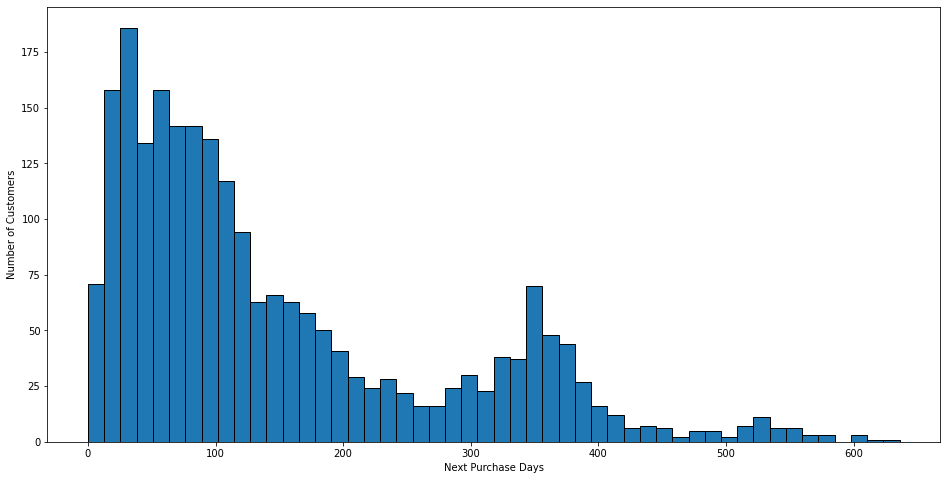

In [12]:
# To filter out NaN from histogram visualization
mask = df_customer['NextPurchaseDay'].dropna()

plt.rcParams["figure.figsize"] = (16,8)
plt.hist(mask, bins=50, edgecolor='black')
plt.xlabel('Next Purchase Days')
plt.ylabel('Number of Customers')
plt.show() 

In [13]:
df_customer = df_customer.fillna(999)

### Feature Engineering 2: Recency and Recency Segment

The next feature that we will add is the recency, which measures whether a customer is an active buyer or not. This can be measured by the time interval between the last purchase day of each customer before cutoff date and the last day before cutoff date.

In [14]:
df_last_purchase['Recency'] = (df_last_purchase['MaxPurchaseDate'].max() - df_last_purchase['MaxPurchaseDate']).dt.days

In [15]:
df_customer = pd.merge(df_customer, df_last_purchase[['CustomerID','Recency']], on='CustomerID')

df_customer.head()

,CustomerID,NextPurchaseDay,Recency
0,14798.0,91.0,44
1,16717.0,48.0,44
2,16202.0,999.0,260
3,14949.0,999.0,359
4,12779.0,152.0,89


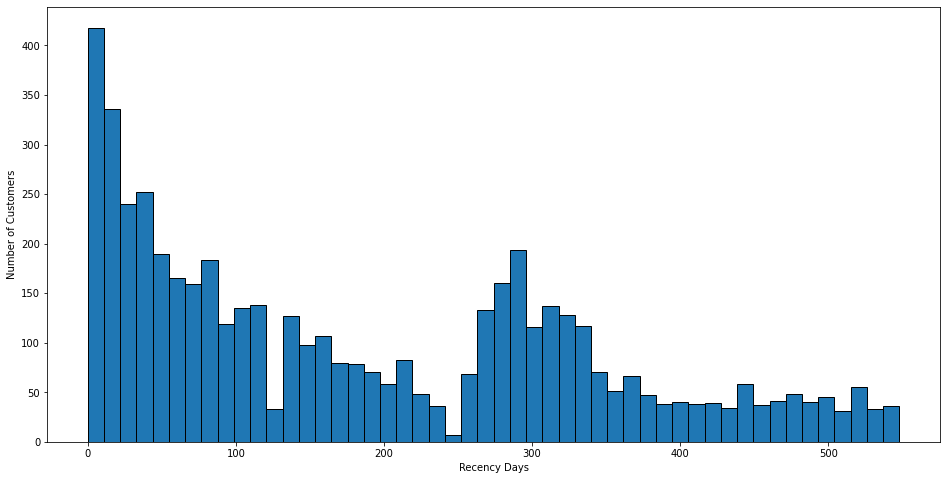

In [16]:
plt.rcParams["figure.figsize"] = (16,8)
plt.hist(df_customer['Recency'], bins=50, edgecolor='black')
plt.xlabel('Recency Days')
plt.ylabel('Number of Customers')
plt.show() 

As we can see, most of the customers have recency below 200 days. Next, let's create another feature, which is a customer segmentation based on their recency days. This is beneficial to assign Recency score later on

But first, we need to find out how many clusters that we should assign. To figure this out, let's do clustering up to 10 clusters and see the error.

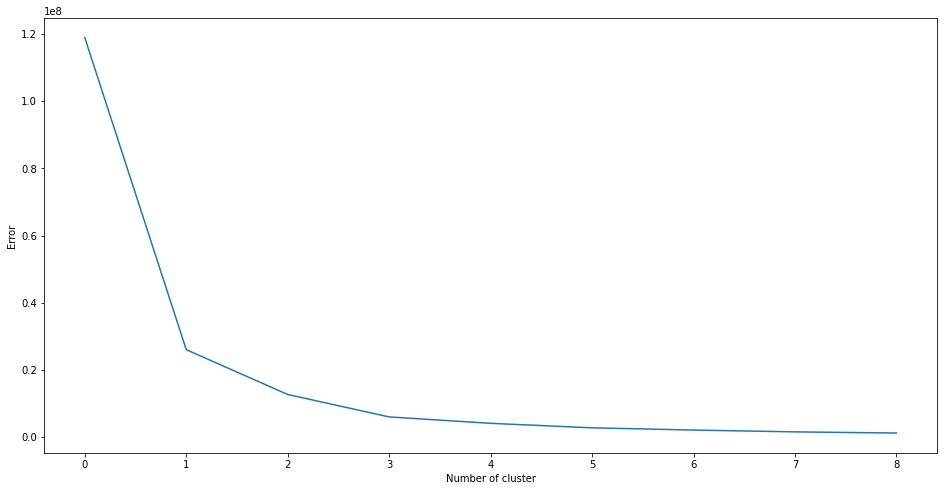

In [17]:
from sklearn.cluster import KMeans

sse= []
customer_recency = df_customer[['Recency']].copy()

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(customer_recency)
    customer_recency['Clusters'] = kmeans.labels_
    sse.append(kmeans.inertia_)

plt.figure()
plt.plot(sse)
plt.xlabel("Number of cluster")
plt.ylabel("Error")
plt.show()

As we can see above, based on elbow method, it seems that 3 clusters would be the optimal one. Hence, we're going to build a recency clustering method with 3 clusters.

In [18]:
# Order cluster number
def order_cluster(cluster_field_name, target_field_name, df, ascending):

    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    
    return df_final

kmeans = KMeans(n_clusters=3)
kmeans.fit(df_customer[['Recency']])
df_customer['RecencyCluster'] = kmeans.predict(df_customer[['Recency']])

df_customer = order_cluster('RecencyCluster', 'Recency', df_customer, False)

In [19]:
df_customer.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster
0,14798.0,91.0,44,2
1,16717.0,48.0,44,2
2,12779.0,152.0,89,2
3,12598.0,90.0,61,2
4,13694.0,14.0,0,2


In [20]:
df_customer.groupby('RecencyCluster').describe()['Recency']

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,685.0,456.487591,52.066438,369.0,412.0,455.0,499.0,548.0
1,1625.0,278.490462,51.492754,171.0,251.0,286.0,318.0,367.0
2,2751.0,62.248637,48.782709,0.0,20.0,50.0,99.0,170.0


Now we can conclude that based on the characteristic of the cluster, the most active customers are grouped together in cluster 2, while the least active customers are grouped together in cluster 0.

### Feature Engineering 3: Frequency and Frequency Segment

The next feature that we should add to our customer dataframe is the frequency. Frequency can be described as the total number of days a customer has made a purchase in our online store, or how frequent are they in purchasing an item in our store. Hence, we can compute this by simply counting the number of days a customer has made a purchase.

In [21]:
df_frequency = df.groupby('Customer ID').InvoiceDate.count().reset_index()
df_frequency.columns = ['CustomerID','Frequency']

In [22]:
df_customer = pd.merge(df_customer, df_frequency, on='CustomerID')

In [23]:
df_customer.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency
0,14798.0,91.0,44,2,51
1,16717.0,48.0,44,2,408
2,12779.0,152.0,89,2,295
3,12598.0,90.0,61,2,211
4,13694.0,14.0,0,2,1558


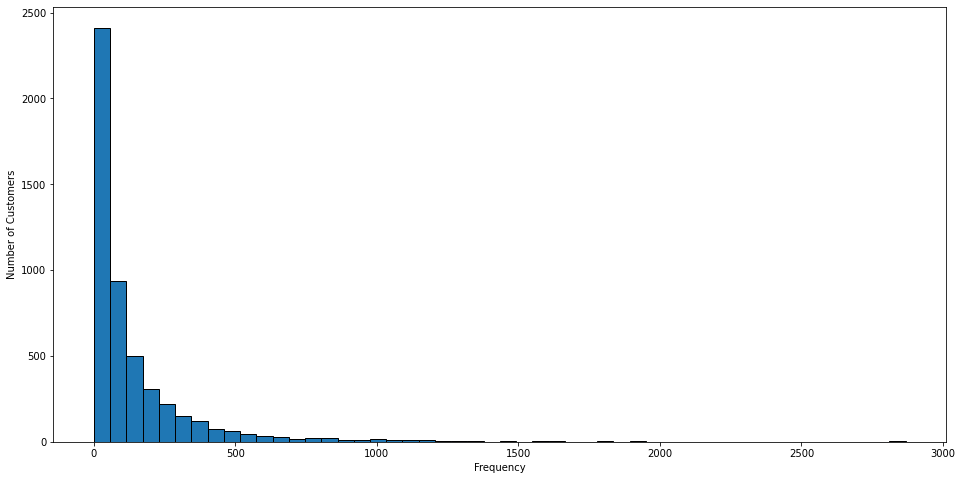

In [24]:
mask = df_customer['Frequency'].loc[df_customer['Frequency'] < 3000]

plt.hist(mask, bins=50, edgecolor='black')
plt.xlabel('Frequency')
plt.ylabel('Number of Customers')
plt.show() 

Now, we do the same again as in the Recency section, where we cluster the customers now based on their Frequency. We're going to build K-Means clustering method also with 3 clusters.

In [25]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_customer[['Frequency']])
df_customer['FrequencyCluster'] = kmeans.predict(df_customer[['Frequency']])

# Order the frequency cluster
df_customer = order_cluster('FrequencyCluster', 'Frequency', df_customer, True)

df_customer.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,4783.0,101.398495,110.145266,1.0,23.00,58.0,140.5,522.0
1,272.0,940.161765,534.495351,524.0,628.00,784.5,1042.5,4130.0
2,6.0,8095.166667,3468.493645,4717.0,5523.25,7008.0,10536.5,13097.0


From the cluster characteristic, we can conclude that the customers with cluster 2 are the most frequent customers to purchase items from the store, while customers with cluster 0 are the least frequent ones.

### Feature Engineering 4: Revenue and Revenue Segment

Next, we can add another feature that will be beneficial for our machine learning model, which is the revenue. Revenue can be described as the amount of money that the store has got from each customer. To compute revenue, we can multiply the item's price with the quantity that each customer has bought.

In [26]:
df['Revenue'] = df['Price'] * df['Quantity']
df_revenue = df.groupby('Customer ID').Revenue.sum().reset_index()
df_revenue.rename(columns={'Customer ID': 'CustomerID'}, inplace=True)

# Merge it with our main dataframe
df_customer = pd.merge(df_customer, df_revenue, on='CustomerID')
df_customer.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,14798.0,91.0,44,2,51,0,715.11
1,16717.0,48.0,44,2,408,0,6309.96
2,12779.0,152.0,89,2,295,0,6406.76
3,12598.0,90.0,61,2,211,0,4414.67
4,14870.0,999.0,161,2,69,0,1794.60


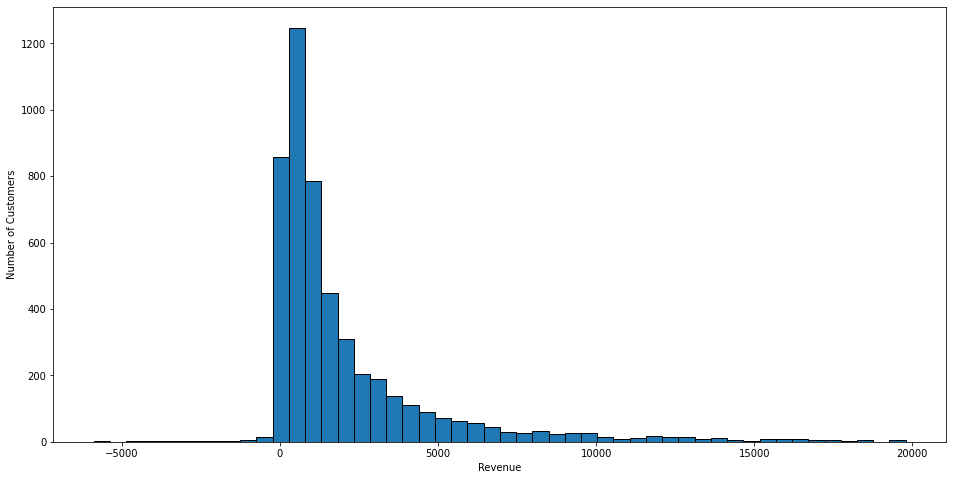

In [27]:
mask = df_customer['Revenue'].loc[(df_customer['Revenue'] < 20000) & (df_customer['Revenue'] > -10000)]

plt.hist(mask, bins=50, edgecolor='black')
plt.xlabel('Revenue')
plt.ylabel('Number of Customers')
plt.show() 

Notice that the store actually lose money from few customers. Next, let's create a customer segmentation based on revenue with K-means clustering. Same as before, the number of cluster assigned would be 3.

In [28]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_customer[['Revenue']])
df_customer['RevenueCluster'] = kmeans.predict(df_customer[['Revenue']])


# Order the cluster numbers
df_customer = order_cluster('RevenueCluster', 'Revenue', df_customer, True)


df_customer.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,5045.0,2550.584874,5295.087355,-25111.09,390.8600,1016.080,2571.0200,73573.47
1,14.0,155460.684286,68782.104825,84269.38,102475.2400,138946.865,186090.6350,296564.69
2,2.0,560778.645000,52943.312094,523342.07,542060.3575,560778.645,579496.9325,598215.22


Same as before, we can interpret the customers in cluster 2 as the customers that generate high revenue to the store, while customers in cluster 0 are the customers that generate the least amount of revenue for the store.

### Feature Engineering 5: Overall Score

The next feature that we should add to our customer dataframe is the overall score. This overall score can be computed based on the combination between each customer's recency cluster, frequency cluster, and revenue cluster. The higher the score, the better the combination of recency, frequency, and revenue from a particular customer.

In [29]:
df_customer['OverallScore'] = df_customer['RecencyCluster'] + df_customer['FrequencyCluster'] + df_customer['RevenueCluster']
df_customer.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,456.487591,36.642336,501.734264
1,278.730031,74.463158,1113.275110
2,66.312977,139.612294,2922.868911
3,32.890625,882.957031,14659.751383
4,11.000000,4092.166667,124237.026667
5,9.750000,5322.000000,376329.722500


As you can see above, if a customer has an overall score of 5, this means that a customer is a 5 star customer. He frequently bought items from the store, he's been active, and he generates a lot of revenue for the store. Vice versa for customer with overall score 0.

In [30]:
df_customer.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore
0,14798.0,91.0,44,2,51,0,715.11,0,2
1,16717.0,48.0,44,2,408,0,6309.96,0,2
2,12779.0,152.0,89,2,295,0,6406.76,0,2
3,12598.0,90.0,61,2,211,0,4414.67,0,2
4,14870.0,999.0,161,2,69,0,1794.60,0,2


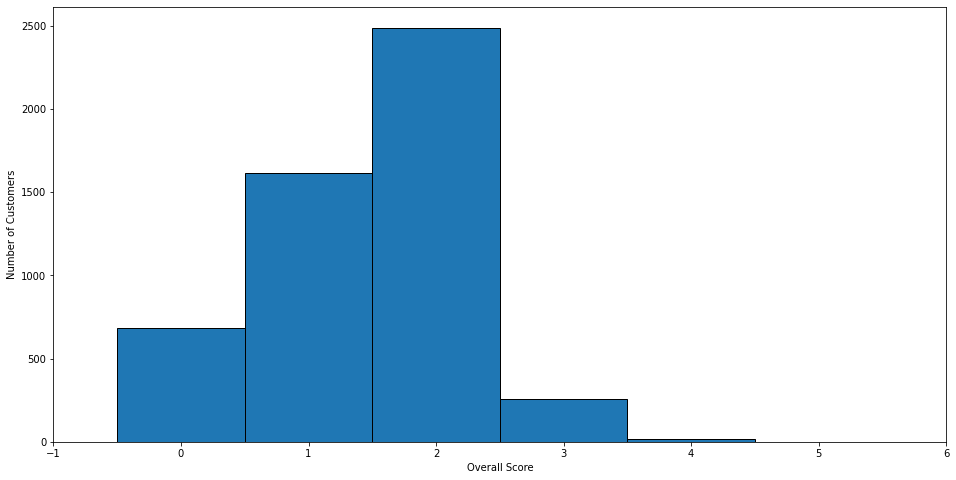

In [31]:
#mask = df_customer['Revenue'].loc[(df_customer['Revenue'] < 20000) & (df_customer['Revenue'] > -10000)]

plt.hist(df_customer['OverallScore'], bins=5, edgecolor='black', align='left')
plt.xlabel('Overall Score')
plt.ylabel('Number of Customers')
plt.xlim([-1, 6])
plt.show()

We can see that most customers have the overall score of 2.

### Feature Engineering 6: Add Days Interval Between Last 3 Purchases

The next features that we should add is basically the date of the last 3 purchases made by each customer before the cutoff date. Below is the implementation for this concept.

In [32]:
# Create a dataframe with CustomerID and Invoice Date

df_day_order = df_18m[['Customer ID','InvoiceDate']].copy()
df_day_order['InvoiceDay'] = df_18m['InvoiceDate'].dt.date
df_day_order = df_day_order.sort_values(['Customer ID','InvoiceDate'])
df_day_order = df_day_order.drop_duplicates(subset=['Customer ID','InvoiceDay'],keep='first')

After we got the last 3 purchases for each customer, we shift the date 3 times. This is beneficial to compute the date interval between the last 3 purchases of each customer.

In [33]:
# Shifting last 3 purchase dates

df_day_order['PrevInvoiceDate'] = df_day_order.groupby('Customer ID')['InvoiceDay'].shift(1)
df_day_order['T2InvoiceDate'] = df_day_order.groupby('Customer ID')['InvoiceDay'].shift(2)
df_day_order['T3InvoiceDate'] = df_day_order.groupby('Customer ID')['InvoiceDay'].shift(3)

In [34]:
df_day_order.head()

,Customer ID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate
1629,12346.0,2010-03-02 13:08:00,2010-03-02,NaN,NaN,NaN
146857,12346.0,2010-06-28 13:53:00,2010-06-28,2010-03-02,NaN,NaN
149415,12346.0,2010-06-30 11:22:00,2010-06-30,2010-06-28,2010-03-02,NaN
263877,12346.0,2010-10-04 09:54:00,2010-10-04,2010-06-30,2010-06-28,2010-03-02
480909,12346.0,2011-01-18 10:01:00,2011-01-18,2010-10-04,2010-06-30,2010-06-28


Below is the implementation of computing the date interval between the last 3 purchases of each customer.

In [35]:
df_day_order['DayDiff'] = (df_day_order['InvoiceDay'] - df_day_order['PrevInvoiceDate']).dt.days
df_day_order['DayDiff2'] = (df_day_order['InvoiceDay'] - df_day_order['T2InvoiceDate']).dt.days
df_day_order['DayDiff3'] = (df_day_order['InvoiceDay'] - df_day_order['T3InvoiceDate']).dt.days

In [36]:
df_day_order.head()

,Customer ID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
1629,12346.0,2010-03-02 13:08:00,2010-03-02,NaN,NaN,NaN,NaN,NaN,NaN
146857,12346.0,2010-06-28 13:53:00,2010-06-28,2010-03-02,NaN,NaN,118.0,NaN,NaN
149415,12346.0,2010-06-30 11:22:00,2010-06-30,2010-06-28,2010-03-02,NaN,2.0,120.0,NaN
263877,12346.0,2010-10-04 09:54:00,2010-10-04,2010-06-30,2010-06-28,2010-03-02,96.0,98.0,216.0
480909,12346.0,2011-01-18 10:01:00,2011-01-18,2010-10-04,2010-06-30,2010-06-28,106.0,202.0,204.0


The last thing that we should do now is computing the mean and standard deviation of the last purchases made by each unique customer ID. Next, we add these two features into our final customer dataframe.

In [37]:
df_day_diff = df_day_order.groupby('Customer ID').agg({'DayDiff': ['mean','std']}).reset_index()
df_day_diff.columns = ['CustomerID', 'DayDiffMean','DayDiffStd']

In [38]:
df_day_order_last = df_day_order.copy().drop_duplicates(subset=['Customer ID'],keep='last')
df_day_order_last.rename(columns={'Customer ID': 'CustomerID'}, inplace=True)

In [39]:
df_day_order_last = df_day_order_last.dropna()
df_day_order_last = pd.merge(df_day_order_last, df_day_diff, on='CustomerID')
df_customer = pd.merge(df_customer, df_day_order_last[['CustomerID','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='CustomerID')

Below is our final customer dataframe that we will use as the data source for our machine learning model.

In [40]:
df_customer.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
0,14798.0,91.0,44,2,51,0,715.11,0,2,166.0,237.0,388.0,72.000,65.589633
1,16717.0,48.0,44,2,408,0,6309.96,0,2,18.0,28.0,166.0,50.400,50.546348
2,12779.0,152.0,89,2,295,0,6406.76,0,2,2.0,9.0,59.0,30.600,31.422922
3,12598.0,90.0,61,2,211,0,4414.67,0,2,59.0,116.0,123.0,60.875,69.509378
4,14870.0,999.0,161,2,69,0,1794.60,0,2,139.0,152.0,237.0,64.500,57.263426


### Add Classification Label

This is the final thing that we need to do before building our machine learning model. Our goal is to predict whether a given customer will purchase an item from the store within the next 3 months. Hence, we are going to transform the `NextPurchaseDay` feature that we have defined before as binary classification. That is, if the next purchase days of a customer is above 90 days or 3 months, then we set the value to 0, otherwise the value will be 1. 



In [41]:
df_customer['NextPurchaseDayRange'] = 1
df_customer.loc[df_customer.NextPurchaseDay>90,'NextPurchaseDayRange'] = 0

In [42]:
df_for_ml = df_customer.drop(['NextPurchaseDay','CustomerID'],axis=1)

In [43]:
df_for_ml.head()

,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,NextPurchaseDayRange
0,44,2,51,0,715.11,0,2,166.0,237.0,388.0,72.000,65.589633,0
1,44,2,408,0,6309.96,0,2,18.0,28.0,166.0,50.400,50.546348,1
2,89,2,295,0,6406.76,0,2,2.0,9.0,59.0,30.600,31.422922,0
3,61,2,211,0,4414.67,0,2,59.0,116.0,123.0,60.875,69.509378,1
4,161,2,69,0,1794.60,0,2,139.0,152.0,237.0,64.500,57.263426,0


## Building ML Model with PyCaret

To build our machine learning model, we are going to use PyCaret, which is a wonderful open-source library that you can use for regression or classification. But why do we need to use PyCaret? Whenever we want to build a machine learning model, often times we don't know which model will yield to the best solution for our problem. We can manually do grid searching and tune the hyperparameter, but it is not that practical. PyCaret gives us the solution for this problem.

First, we specify our input dataframe and we need to specify the column that serves as the label.

In [44]:
exp_mclf101 = setup(data = df_for_ml, target = 'NextPurchaseDayRange', session_id=123)

,Description,Value
0,session_id,123
1,Target,NextPurchaseDayRange
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(2144, 13)"
5,Missing Values,False
6,Numeric Features,8
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


Next, we can use `compare_models()` method fromPyCaret to see which model will yield to the best result according to the metrics of our choice.

In [84]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.8460,0.9210,0.8257,0.7826,0.8022,0.6764,0.6787,0.145
lda,Linear Discriminant Analysis,0.8453,0.9209,0.8204,0.7834,0.8007,0.6745,0.6759,0.019
lr,Logistic Regression,0.8447,0.9299,0.8117,0.7863,0.7980,0.6720,0.6731,0.412
ridge,Ridge Classifier,0.8440,0.0000,0.8222,0.7798,0.7996,0.6721,0.6737,0.015
gbc,Gradient Boosting Classifier,0.8440,0.9266,0.8185,0.7833,0.7985,0.6715,0.6743,0.285
rf,Random Forest Classifier,0.8427,0.9236,0.7939,0.7938,0.7920,0.6656,0.6676,0.565
et,Extra Trees Classifier,0.8260,0.9187,0.7500,0.7843,0.7658,0.6276,0.6289,0.504
lightgbm,Light Gradient Boosting Machine,0.8207,0.9120,0.7835,0.7570,0.7677,0.6220,0.6248,0.146
nb,Naive Bayes,0.8153,0.9086,0.6338,0.8394,0.7207,0.5872,0.6011,0.016
dt,Decision Tree Classifier,0.7800,0.7665,0.7111,0.7114,0.7101,0.5330,0.5342,0.020


From the list of models above, it can be seen that AdaBoost performed the best compared to other. Hence, we are going to implement AdaBoost for our use case.

In [123]:
ada = create_model('ada')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8533,0.9232,0.8772,0.7692,0.8197,0.6970,0.7012
1,0.8533,0.9391,0.8596,0.7778,0.8167,0.6950,0.6974
2,0.8133,0.8919,0.8246,0.7231,0.7705,0.6143,0.6181
3,0.8600,0.9341,0.8596,0.7903,0.8235,0.7078,0.7096
4,0.8267,0.9112,0.7368,0.7925,0.7636,0.6271,0.6281
5,0.8533,0.9257,0.7895,0.8182,0.8036,0.6866,0.6869
6,0.8867,0.9271,0.8947,0.8226,0.8571,0.7635,0.7653
7,0.8200,0.9103,0.7719,0.7586,0.7652,0.6193,0.6194
8,0.8267,0.9188,0.8571,0.7273,0.7869,0.6425,0.6486
9,0.8667,0.9286,0.7857,0.8462,0.8148,0.7109,0.7121


We could also tune the hyperparameter automatically with `tune_model()` method.

In [125]:
tuned_ada = tune_model(ada)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8333,0.9211,0.8596,0.7424,0.7967,0.6568,0.6619
1,0.8467,0.9234,0.8772,0.7576,0.8130,0.6842,0.6895
2,0.8267,0.9004,0.8421,0.7385,0.7869,0.6419,0.6458
3,0.8667,0.9425,0.8772,0.7937,0.8333,0.7227,0.7252
4,0.8733,0.9225,0.8421,0.8276,0.8348,0.7321,0.7322
5,0.8667,0.9351,0.8246,0.8246,0.8246,0.7170,0.7170
6,0.8867,0.9242,0.9123,0.8125,0.8595,0.7651,0.7687
7,0.8467,0.9204,0.7895,0.8036,0.7965,0.6735,0.6735
8,0.8333,0.9229,0.8393,0.7460,0.7899,0.6526,0.6557
9,0.8667,0.9510,0.7679,0.8600,0.8113,0.7087,0.7115


In [126]:
print(tuned_ada)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.2,
                   n_estimators=230, random_state=123)


In [128]:
evaluate_model(tuned_ada)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Predict Test Data

Whenever we built our PyCaret environment in the beginning, PyCaret will automatically allocate around 20% of the input data into test data. The accuracy that we got from the table above is solely based on the training data that is automatically generated by PyCaret.  Hence, we can test the model prediction on this unseen test data.

In [88]:
predict_model(tuned_ada);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.8556,0.9366,0.8197,0.8032,0.8114,0.6944,0.6945


As we can see, the accuracy of the model on test data is also similar with the training data, at around 85%. This means that we don't have overfitting problem and also, our model can generalize on unseen data relatively well.